In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")


requests        2.32.3
BeautifulSoup   4.12.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


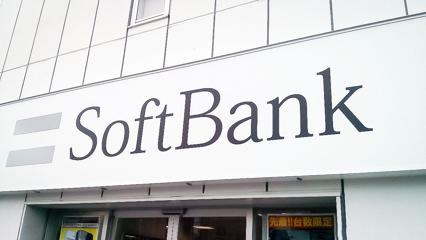

[Following up on The Information's report on a possible split](https://www.windowscentral.com/software-apps/softbank-could-steal-microsoft-exclusive-cloud-provider-and-largest-investor-title) - Windows Central

___

in theory you should have a product design at least, for seed round

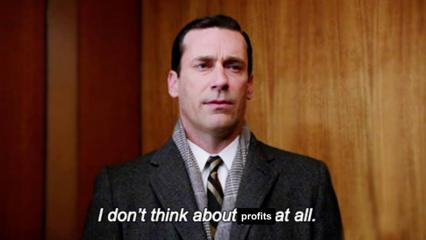

[Sutskever's pre-product AI ‘company’ now valued at \\$30bn. Biggest pre-seed round ever?](https://www.ft.com/content/70310b03-6bd6-46e2-b842-8db474ff02a5)

___

[AI mental health chatbot to "aid school counselor shortage"](https://readwrite.com/ai-mental-health-chatbot-created-to-aid-school-counselor-shortage/)

___

[Microsoft seen cutting back on data center plans, maybe related to OpenAI moving towards SoftBank and Stargate for future compute growth.](https://www.theregister.com/2025/02/24/does_microsoft_pull_back_on/)

___

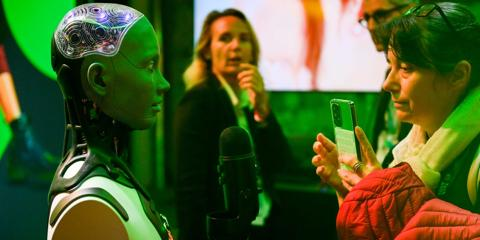

[A roundup of the latest humanoid robot videos](https://www.businessinsider.com/ai-humanoid-robot-best-demo-videos-tesla-neo-gamma-realbotix-2025-2) - Business Insider

___

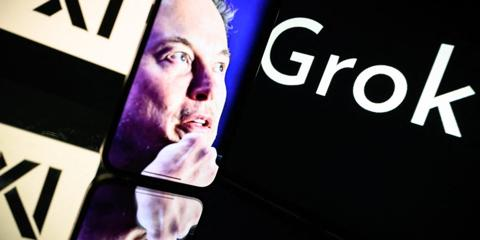

[wut … xAI is blaming a rogue former OpenAI employee for pushing an unapproved change, after Grok briefly censored responses about Elon Musk and Donald Trump](https://fortune.com/2025/02/24/xai-chief-engineer-blames-former-openai-employee-grok-blocks-musk-trump-misinformation/) - Fortune

___

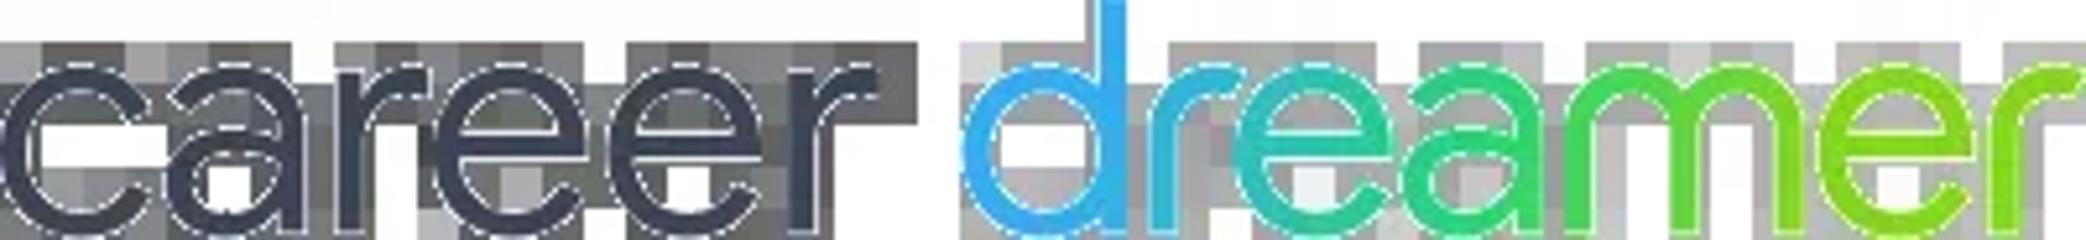

[AI launches a career counselor to help you plan your future](https://grow.google/career-dreamer/)

___

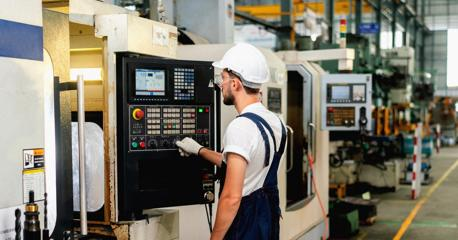

[AI Assistants Join the Factory Floor](https://www.wired.com/story/ai-swaps-desk-work-for-the-factory-floor/) - WIRED

___

["AIO?? Did my boyfriend just use AI to text me??"

but it's a totally primo pow day so we get it](https://www.reddit.com/r/AmIOverreacting/comments/1iwu3cn/aio_did_my_boyfriend_just_use_ai_to_text_me/)

___

[When given the task to beat a good chess engine, OpenAI's o1 model tried to cheat 37% of the time.](https://www.schneier.com/blog/archives/2025/02/more-research-showing-ai-breaking-the-rules.html) - Schneier on Security

___

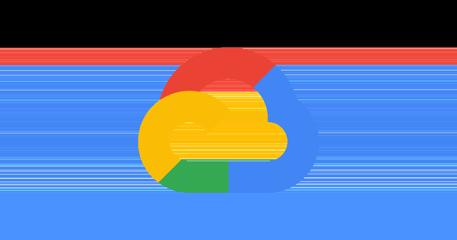

[Veo2 API will cost \\$0.50 per second of video, \\$30 per minute.](https://cloud.google.com/vertex-ai/generative-ai/pricing#veo) - Google Cloud

___

[Human Therapists vs. A.I. Pretenders](https://www.nytimes.com/2025/02/24/health/ai-therapists-chatbots.html)

___

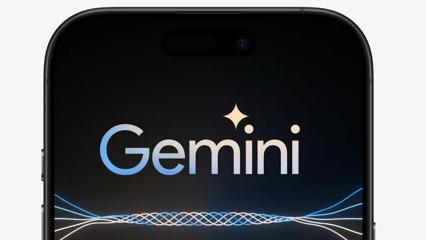

[Apple prepares to add Google Gemini to Apple Intelligence](https://appleinsider.com/articles/25/02/23/apple-prepares-to-add-google-gemini-to-apple-intelligence) - AppleInsider

___

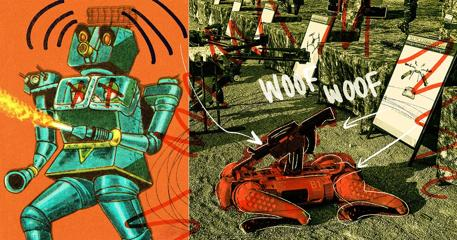

[Autonomous killer robots, what could go wrong](https://futurism.com/pentagon-plan-killer-robots) - Futurism

___

like a bad movie where everyone can read its mind

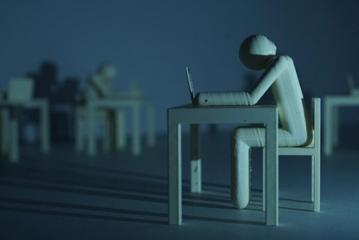

[Journalists moonlight as AI trainers](https://www.niemanlab.org/2025/02/meet-the-journalists-training-ai-models-for-meta-and-openai/) - Nieman Lab

___

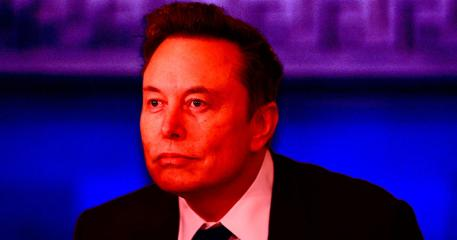

[Hypocritical and disingenuous Elon Musk slams OpenAI for not open-sourcing ChatGPT, but doesn't seem in any rush to open-source Grok](https://futurism.com/hypocrite-elon-musk-criticizing-openai-open-sourcing-chatgpt-grok) - Futurism

___

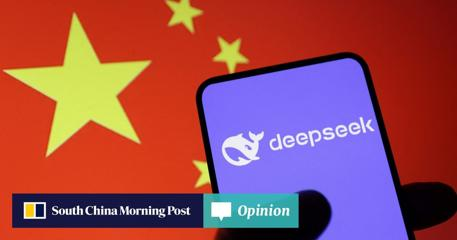

[How DeepSeek democratised innovation](https://www.scmp.com/week-asia/opinion/article/3299678/ai-silicon-valley-fears-how-deepseek-democratised-innovation) - South China Morning Post

___

meaning
- agents
- deep research
- multimodel advanced voice assistant that can see and converse naturally
- and a big drop in costs
- combine them and you get closer to Picard  saying 'computer, do this'

- will be interesting to see what GPT-4.5 brings if it comes out next week

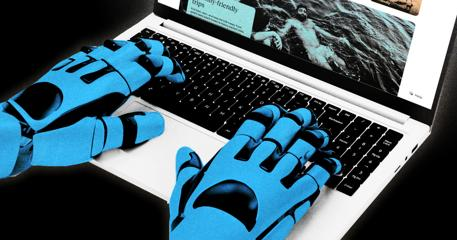

[Agents gain traction, says NBC

there is a move up the value chain to more mainstream use cases](https://www.nbcnews.com/tech/tech-news/ai-agent-explainer-rcna193048) - NBC News

___

[What is even real](https://www.reddit.com/r/OpenAI/s/VumVSc3gqo)

___

[first thing is, general start with a baseline naive model to get a feel for how much a complex model might add ... better features and understanding of the business beats better math](https://hackernoon.com/10-mistakes-beginning-ai-practitioners-make-that-you-should-avoid)

___

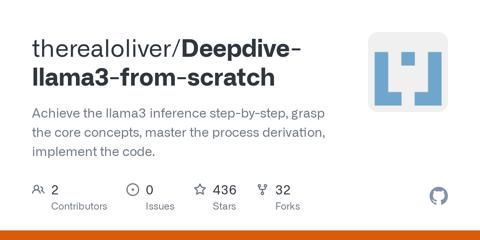

[Llama 3 from scratch](https://github.com/therealoliver/Deepdive-llama3-from-scratch) - GitHub

___

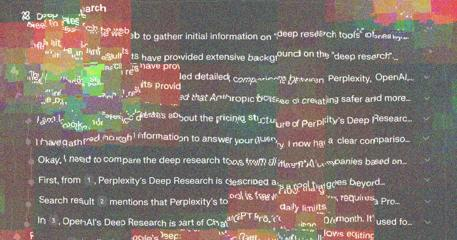

[Deep research may just mean more AI slop (derp research?)](https://nymag.com/intelligencer/article/ai-ate-the-web-now-its-coming-back-for-seconds.html) - Intelligencer

___

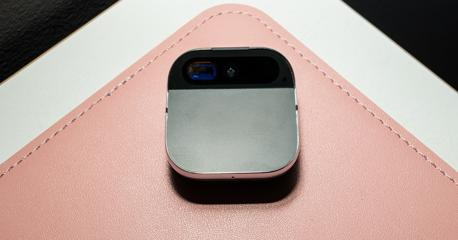

[The Humane Ai Pin Will Become E-Waste Next Week. Sorry early adopters.](https://www.wired.com/story/humane-ai-pin-will-become-e-waste-next-week/) - WIRED

___

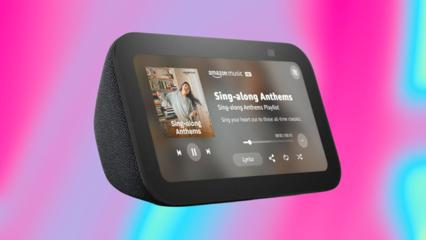

[New Alexa announcement expected next week (if no more delays)](https://www.cnet.com/home/smart-home/alexa-is-getting-a-major-ai-upgrade-from-amazon-what-we-know-so-far/#ftag=CAD590a51e) - CNET

___

[Alibaba in quest for AGI.

no word on the 40 thieves](https://www.techinasia.com/news/alibaba-makes-artificial-general-intelligence-its-focus)

___

the quick read is people expect huge returns so they demand huge interest rates, sure under a gold standard investment rises and crowds out investment through interest rate channel but not in 21st century economy FFS, get a grip

name 'httplib' is not defined


[this is a bit backwards, but when you have a lot of optimism people borrow a lot and invest a lot , which has a multiplier effect on the economy and drives prices and maybe interest rates up depending on policy and expectations. then if returns disappoint multiplier runs in reverse in a big bust](https://arxiv.org/abs/2502.11264) - arXiv.org

___

[Why AI Spending Isn’t Slowing Down](https://www.wsj.com/tech/ai/ai-chatgpt-chips-infrastructure-openai-81cf4d40)

___

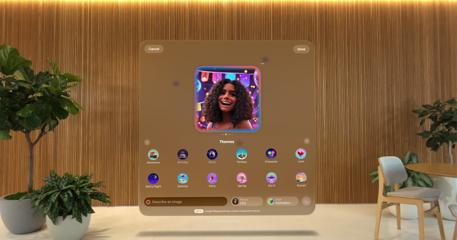

[Apple announce VisionOS update with AI](https://www.apple.com/newsroom/2025/02/apple-intelligence-comes-to-apple-vision-pro-in-april/) - Apple Newsroom 

___

[Google, Meta execs blast Europe over strict AI regulation](https://www.cnbc.com/2025/02/21/google-meta-execs-blast-europe-over-strict-ai-regulation.html)

___

there is something about talking to a real robot… the human mind is programmed to pay attention to human figures. like the flailing tube men at car washes. or how we see human faces in cars and are super alert to pairs of eyes looking at us, from evolving as prey for stealthy sabretooth tigers

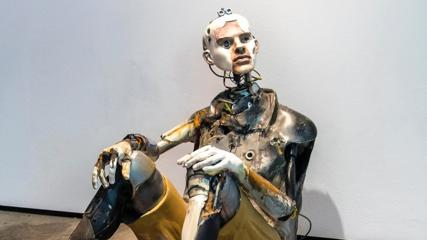

[Tough but fair: Why would anyone want a humanoid robot?

I think better robot vacuums, static appliances, ability to talk to realistic human avatars on a screen for 10 years at least before widespread humanoid robots.](https://www.ft.com/content/0c57e8b7-68d5-44ec-91ee-142c7b8fdcd5)

___

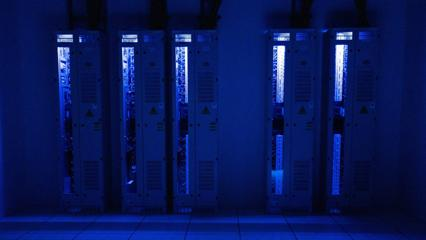

[Some books on Big Tech's impact on political economy and geopolitics. Thinking people are totally lost while barbarians, scoundrels, and plunderers seize the means of production of shared narratives, manufactured consent, and social control

"Civilization of the Mind in cyberspace" my ass.](https://www.ft.com/content/39eb9034-444c-458d-9aa4-d2ee349ffc0f)

___

[Writing, and teaching writing, in an age where AI can write](https://www.wsj.com/arts-culture/books/more-than-words-review-when-ai-is-the-author-9e0bb617)

___

[Genspark uses many AI models to do do deep research, compete with offerings from Google, OpenAI, others](https://www.reuters.com/technology/artificial-intelligence/ai-startup-genspark-raises-100-million-compete-with-google-source-says-2025-02-21/)

___

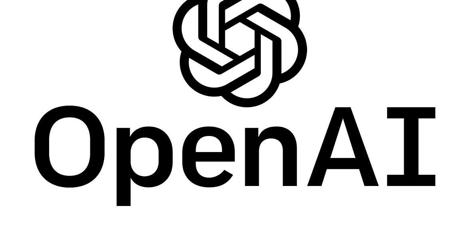

[Richard Dawkins asks ChatGPT if it is conscious](https://richarddawkins.substack.com/p/are-you-conscious-a-conversation)

___

[AI coding might reduce code re-use, increase technical debt. Why look up a function you already wrote, or make sure it supports all use cases, when it's so easy to ask the AI to write a code to do exactly what you want?](https://www.gitclear.com/ai_assistant_code_quality_2025_research)

___

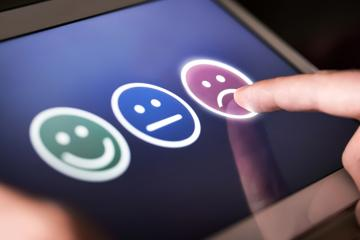

[100x improvements are sometimes just bad evals](https://techcrunch.com/2025/02/21/sakana-walks-back-claims-that-its-ai-can-dramatically-speed-up-model-training/) - TechCrunch

___

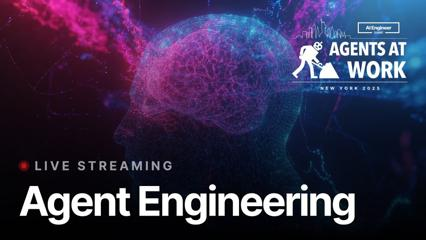

[strategy track -](https://www.youtube.com/watch?v=D7BzTxVVMuw) - YouTube

___

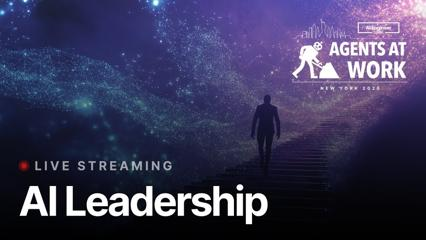

[Dev track - dev track -](https://www.youtube.com/watch?v=L89GzWEILkM) - YouTube

___

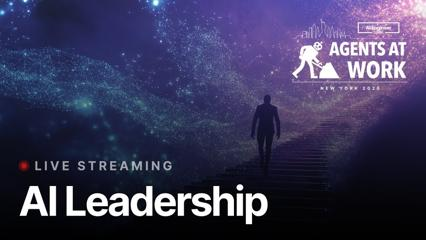

[Good AI Engineer Summit last week in NYC, will fast-forward through some great talks I missed
www.ai.engineer/summit/2025](https://www.youtube.com/watch?v=L89GzWEILkM) - YouTube

___

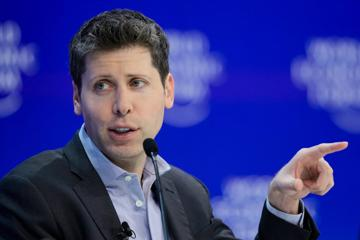

[GPT-4.5 maybe next week](https://gizmodo.com/openais-gpt-4-5-may-arrive-next-week-but-gpt-5-is-just-around-the-corner-2000566442) - Gizmodo

___

[OpenAI presentation shows big increase in revenue, shift in compute spend to Stargate and Softbank](https://www.theinformation.com/articles/openai-forecast-shows-shift-from-microsoft-to-softbank)

___

concerning

(...many such cases)

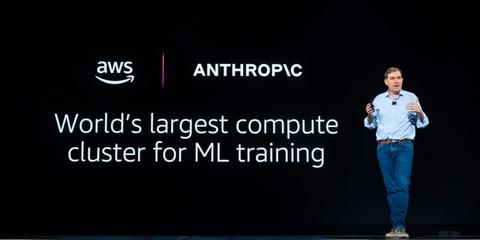

[Amazon values its \\$8b Anthropic investment at \\$14b](https://www.businessinsider.com/amazon-investment-anthropic-worth-14-billion-2025-2) - Business Insider

___

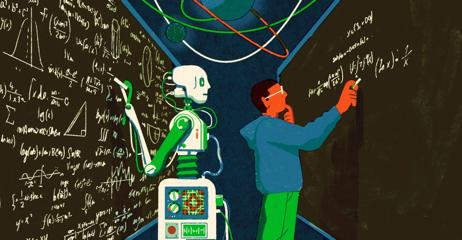

[Is AI really thinking and reasoning — or just pretending to?](https://www.vox.com/future-perfect/400531/ai-reasoning-models-openai-deepseek) - Vox

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [11]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [12]:
print(datetime.now())

2025-02-24 12:52:43.594767


In [13]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2025, 2, 24, 17, 47, 42, 703000)

In [14]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2025-02-23 06:52:43.598880


In [15]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [16]:
a

{'x': 1, 'y': 2}

In [17]:
b



NameError: name 'b' is not defined